In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import os


In [12]:

# ✅ Load segmented data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")
print(f"Original class distribution: {Counter(y)}")


Original class distribution: Counter({0: 784535, 1: 4467, 5: 2466, 2: 1093})


In [13]:

# ✅ Flatten + scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)


In [14]:

# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [15]:

# ✅ SMOTE + undersample
target_count = 70000
print(f"Original train distribution: {Counter(y_train)}")

minority_classes = [cls for cls in Counter(y_train) if cls != 0]
smote_strategy = {cls: target_count for cls in minority_classes}

sm = SMOTE(random_state=42, sampling_strategy=smote_strategy)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rus = RandomUnderSampler(
    sampling_strategy={0: target_count, **{cls: target_count for cls in np.unique(y_train_res) if cls != 0}},
    random_state=42
)
X_train_bal, y_train_bal = rus.fit_resample(X_train_res, y_train_res)
print(f"Balanced train: {Counter(y_train_bal)}")


Original train distribution: Counter({0: 627627, 1: 3574, 5: 1973, 2: 874})
Balanced train: Counter({0: 70000, 1: 70000, 2: 70000, 5: 70000})


In [16]:

# ✅ Remap labels
label_map = {0: 0, 1: 1, 2: 2, 5: 3}
class_names = ["Fusion beat", "Normal beat", "Supraventricular ectopic beat", "Ventricular ectopic beat"]

y_train_bal = np.array([label_map[label] for label in y_train_bal])
y_test_remap = np.array([label_map[label] for label in y_test])


In [17]:

# ✅ Reshape for CNN
time_steps = X.shape[1]
X_train_cnn = X_train_bal.reshape((-1, 1, time_steps)).astype(np.float32)
X_test_cnn = X_test.reshape((-1, 1, time_steps)).astype(np.float32)


In [18]:

# ✅ Tensors + datasets
X_train_tensor = torch.tensor(X_train_cnn)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn)
y_test_tensor = torch.tensor(y_test_remap, dtype=torch.long)

train_ds_full = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

val_size = int(0.2 * len(train_ds_full))
train_size = len(train_ds_full) - val_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [19]:

# ✅ Model
class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ECG_CNN(len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:

# ✅ Training loop
num_epochs = 70
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/70 | Train Loss: 0.7781 | Val Loss: 0.6278 | Train Acc: 0.6993 | Val Acc: 0.7639
Epoch 2/70 | Train Loss: 0.5610 | Val Loss: 0.4849 | Train Acc: 0.7931 | Val Acc: 0.8292
Epoch 3/70 | Train Loss: 0.4095 | Val Loss: 0.3715 | Train Acc: 0.8531 | Val Acc: 0.8682
Epoch 4/70 | Train Loss: 0.3180 | Val Loss: 0.2941 | Train Acc: 0.8862 | Val Acc: 0.8960
Epoch 5/70 | Train Loss: 0.2654 | Val Loss: 0.2292 | Train Acc: 0.9059 | Val Acc: 0.9200
Epoch 6/70 | Train Loss: 0.2321 | Val Loss: 0.2239 | Train Acc: 0.9177 | Val Acc: 0.9173
Epoch 7/70 | Train Loss: 0.2051 | Val Loss: 0.1965 | Train Acc: 0.9270 | Val Acc: 0.9329
Epoch 8/70 | Train Loss: 0.1864 | Val Loss: 0.1772 | Train Acc: 0.9343 | Val Acc: 0.9377
Epoch 9/70 | Train Loss: 0.1699 | Val Loss: 0.1548 | Train Acc: 0.9406 | Val Acc: 0.9454
Epoch 10/70 | Train Loss: 0.1580 | Val Loss: 0.1446 | Train Acc: 0.9453 | Val Acc: 0.9504
Epoch 11/70 | Train Loss: 0.1474 | Val Loss: 0.1338 | Train Acc: 0.9489 | Val Acc: 0.9553
Epoch 12/70 | Train

In [21]:

# ✅ Save model + history
save_dir = "C:/Users/arfao/Desktop/stage_2025/cnn_results"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, 'ecg_cnn_model.pth'))
np.save(os.path.join(save_dir, 'ecg_cnn_history.npy'), history)


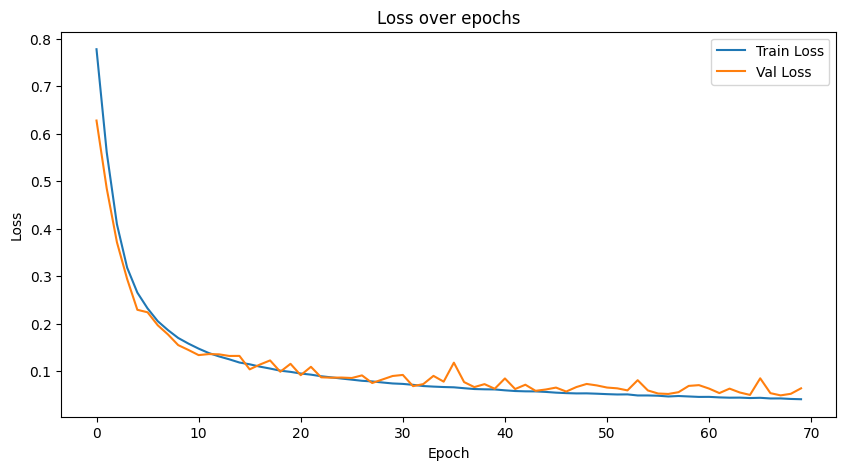

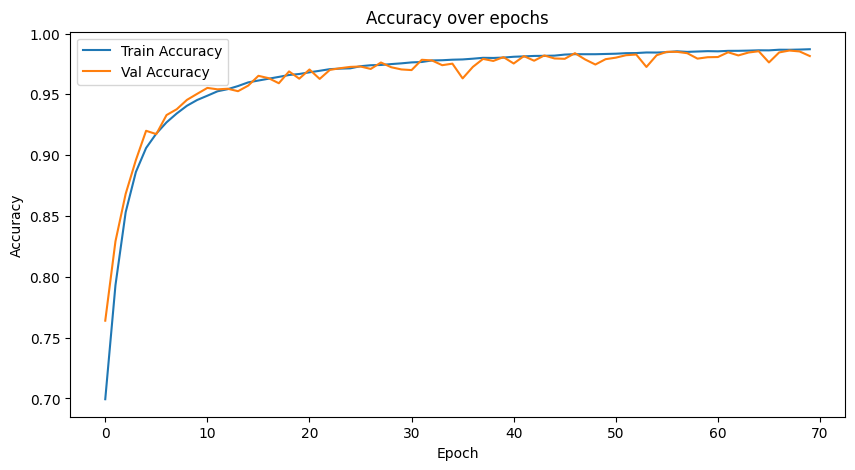

In [22]:

# ✅ Plots
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [23]:

# ✅ Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
                               precision    recall  f1-score   support

                  Fusion beat       1.00      0.97      0.98    156908
                  Normal beat       0.37      0.98      0.54       893
Supraventricular ectopic beat       0.06      0.62      0.12       219
     Ventricular ectopic beat       0.26      0.92      0.40       493

                     accuracy                           0.97    158513
                    macro avg       0.42      0.87      0.51    158513
                 weighted avg       0.99      0.97      0.98    158513



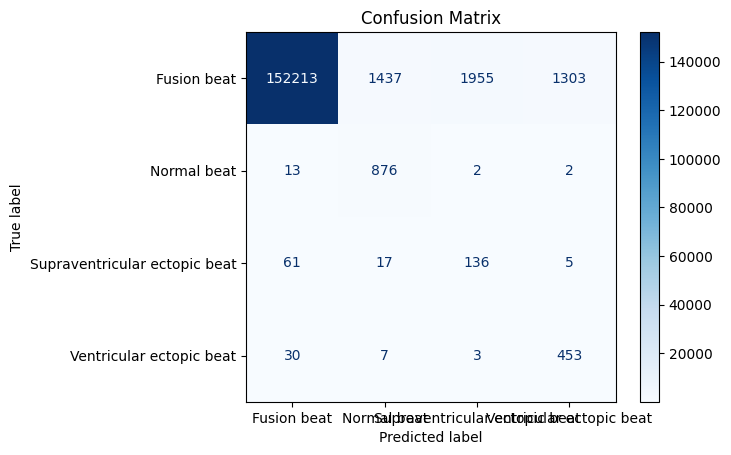

In [24]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


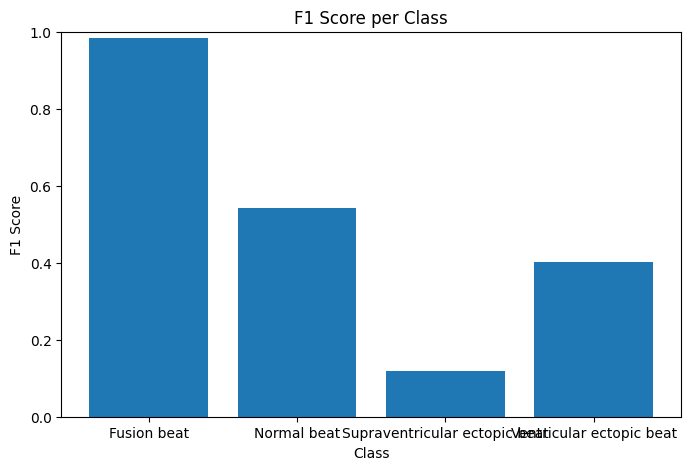

In [25]:

f1_per_class = f1_score(all_labels, all_preds, average=None)
plt.figure(figsize=(8,5))
plt.bar(class_names, f1_per_class)
plt.title("F1 Score per Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()


Original class distribution: Counter({0: 784535, 1: 4467, 5: 2466, 2: 1093})


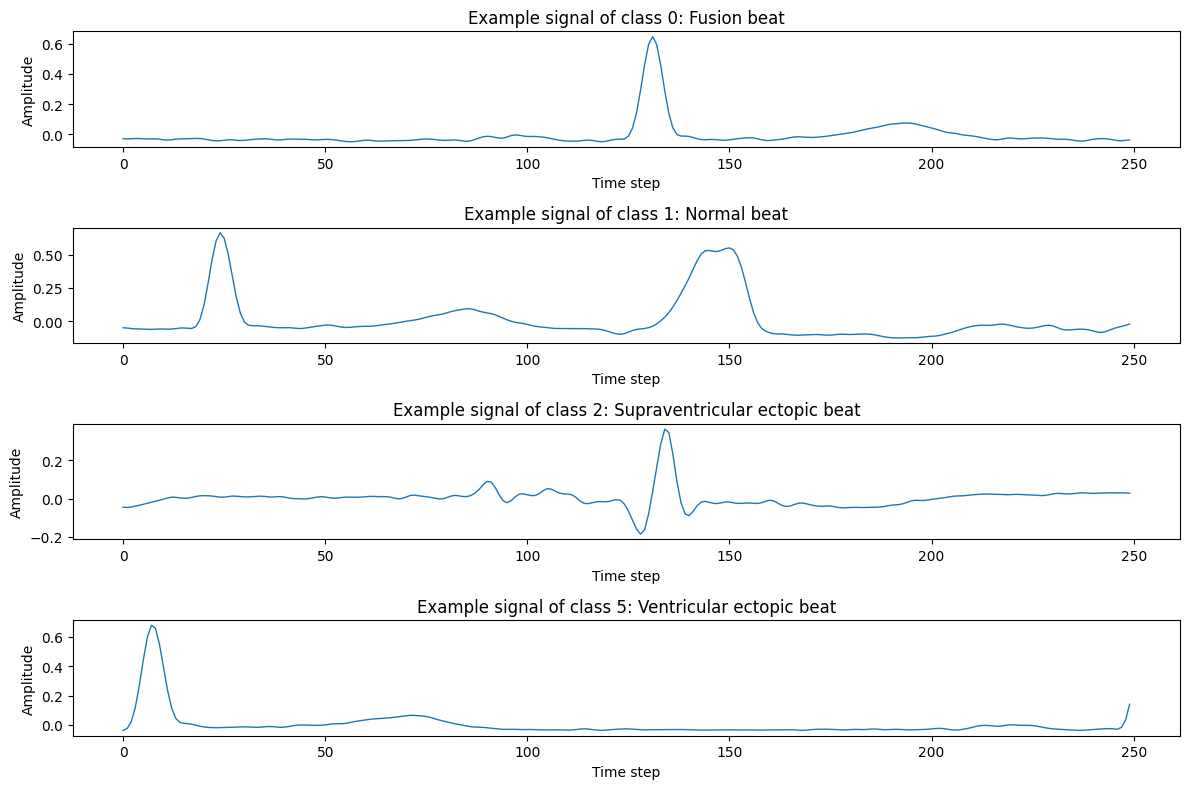

Balanced dataset: Counter({0: 70000, 1: 70000, 2: 70000, 5: 70000})
Epoch 1/50 | Train Loss: 0.8223 | Val Loss: 0.6955 | Train Acc: 0.6779 | Val Acc: 0.7373
Epoch 2/50 | Train Loss: 0.6291 | Val Loss: 0.5820 | Train Acc: 0.7599 | Val Acc: 0.7756
Epoch 3/50 | Train Loss: 0.5417 | Val Loss: 0.5069 | Train Acc: 0.7952 | Val Acc: 0.8071
Epoch 4/50 | Train Loss: 0.4785 | Val Loss: 0.4548 | Train Acc: 0.8199 | Val Acc: 0.8296
Epoch 5/50 | Train Loss: 0.4294 | Val Loss: 0.4304 | Train Acc: 0.8391 | Val Acc: 0.8416
Epoch 6/50 | Train Loss: 0.3887 | Val Loss: 0.3790 | Train Acc: 0.8559 | Val Acc: 0.8600
Epoch 7/50 | Train Loss: 0.3508 | Val Loss: 0.3270 | Train Acc: 0.8710 | Val Acc: 0.8827
Epoch 8/50 | Train Loss: 0.3202 | Val Loss: 0.3213 | Train Acc: 0.8833 | Val Acc: 0.8837
Epoch 9/50 | Train Loss: 0.2938 | Val Loss: 0.2758 | Train Acc: 0.8940 | Val Acc: 0.9027
Epoch 10/50 | Train Loss: 0.2727 | Val Loss: 0.2635 | Train Acc: 0.9022 | Val Acc: 0.9070
Epoch 11/50 | Train Loss: 0.2568 | Val Lo

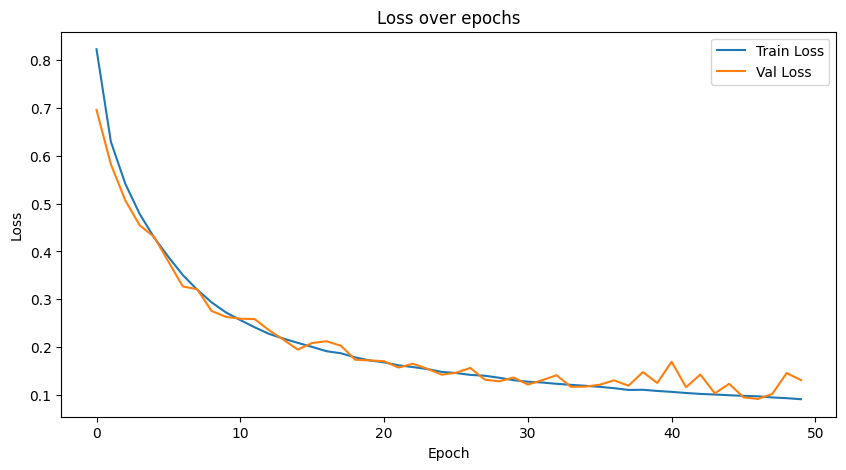

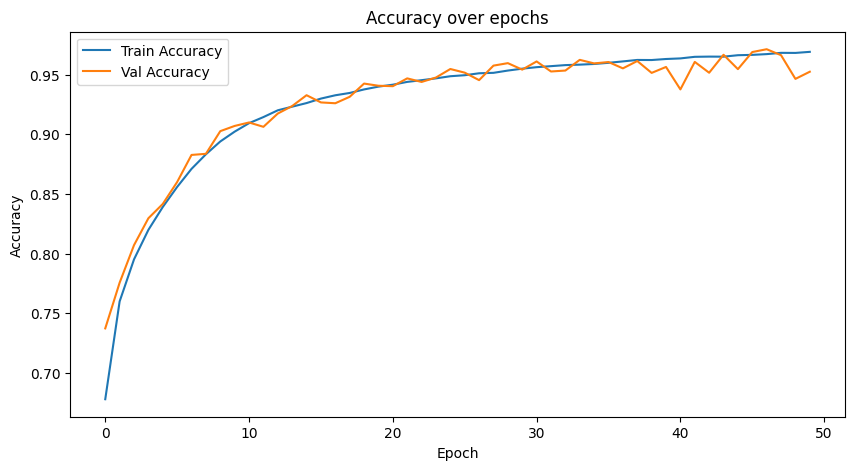

Classification Report:
                               precision    recall  f1-score   support

                  Fusion beat       0.87      0.97      0.92     14000
                  Normal beat       0.98      0.98      0.98     14000
Supraventricular ectopic beat       0.98      0.88      0.93     14000
     Ventricular ectopic beat       0.99      0.97      0.98     14000

                     accuracy                           0.95     56000
                    macro avg       0.96      0.95      0.95     56000
                 weighted avg       0.96      0.95      0.95     56000



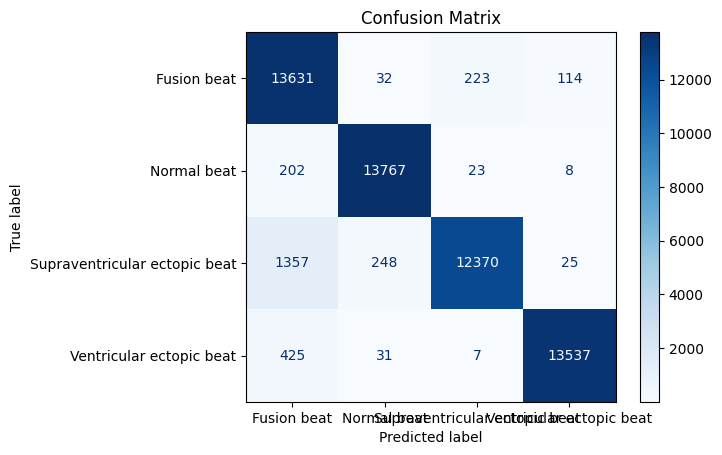

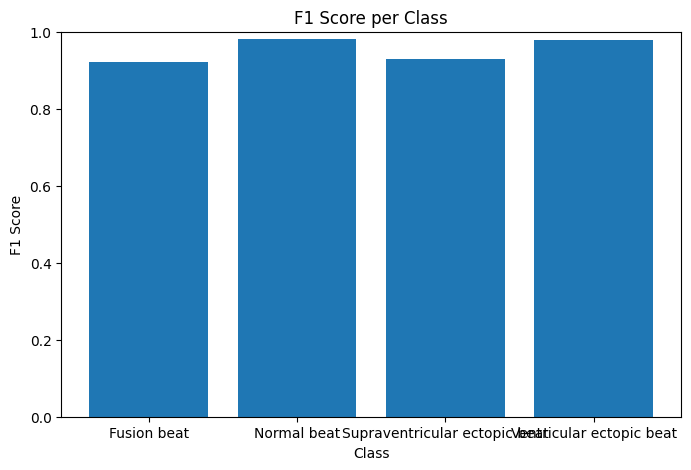

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import os

# ✅ Load segmented data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")
print(f"Original class distribution: {Counter(y)}")

# ✅ Plot original class samples
label_name_map = {0: "Fusion beat", 1: "Normal beat", 2: "Supraventricular ectopic beat", 5: "Ventricular ectopic beat"}
unique_classes = np.unique(y)
plt.figure(figsize=(12, 8))
for i, class_label in enumerate(unique_classes):
    idx = (y == class_label).nonzero()[0][0]
    plt.subplot(len(unique_classes), 1, i + 1)
    plt.plot(X[idx], linewidth=1)
    plt.title(f"Example signal of class {class_label}: {label_name_map.get(class_label, 'Unknown')}")
    plt.xlabel("Time step")
    plt.ylabel("Amplitude")
    plt.tight_layout()
plt.show()

# ✅ Flatten + scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# ✅ Apply augmentation
target_count = 70000
minority_classes = [cls for cls in Counter(y) if cls != 0]
smote_strategy = {cls: target_count for cls in minority_classes}

sm = SMOTE(random_state=42, sampling_strategy=smote_strategy)
X_res, y_res = sm.fit_resample(X_scaled, y)

rus = RandomUnderSampler(
    sampling_strategy={0: target_count, **{cls: target_count for cls in np.unique(y_res) if cls != 0}},
    random_state=42
)
X_bal, y_bal = rus.fit_resample(X_res, y_res)
print(f"Balanced dataset: {Counter(y_bal)}")

# ✅ Split after augmentation
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

# ✅ Remap labels
label_map = {0: 0, 1: 1, 2: 2, 5: 3}
class_names = ["Fusion beat", "Normal beat", "Supraventricular ectopic beat", "Ventricular ectopic beat"]

y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

# ✅ Reshape for CNN
time_steps = X.shape[1]
X_train_cnn = X_train.reshape((-1, 1, time_steps)).astype(np.float32)
X_test_cnn = X_test.reshape((-1, 1, time_steps)).astype(np.float32)

# ✅ Tensors + datasets
X_train_tensor = torch.tensor(X_train_cnn)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds_full = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

val_size = int(0.2 * len(train_ds_full))
train_size = len(train_ds_full) - val_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# ✅ Model
class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ECG_CNN(len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training loop with plots
num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ✅ Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

f1_per_class = f1_score(all_labels, all_preds, average=None)
plt.figure(figsize=(8,5))
plt.bar(class_names, f1_per_class)
plt.title("F1 Score per Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()
